In [2]:
import h5py
import numpy as np  
import torch
from tqdm import tqdm   

## Quark-Gluon dataset:
train: 793.9K <br>
valid: 83.8K <br>
test: 55.4K <br>

## Boosted-Top dataset:
train: 3.164 M <br> 
valid: 393.6K<br>
test: 400K<br>

In [6]:
# data = h5py.File('/global/cfs/cdirs/m4392/ACAT_Backup/Data/QG/Quark_Gluon.h5', 'r')  
data = h5py.File('/global/cfs/cdirs/m4392/ACAT_Backup/Data/Top/Boosted_Top.h5', 'r')  

In [7]:
data.keys()

<KeysViewHDF5 ['test_jet', 'test_meta', 'train_jet', 'train_meta', 'validation_jet', 'validation_meta']>

In [8]:
data['train_meta'].shape

(3164800, 3)

In [10]:
data['train_meta'][4]

array([  0.     , 224.64825, 936.9446 ], dtype=float32)

In [21]:
h5_path = '/global/cfs/cdirs/m4392/ACAT_Backup/Data/QG/Quark_Gluon.h5'
# h5_path = '/global/cfs/cdirs/m4392/ACAT_Backup/Data/Top/Boosted_Top.h5'
# h5_file = h5py.File(h5_path, 'r', libver='latest', swmr=True)
# data = h5_file['train_jet']
# print(data.chunks)

In [22]:
from utils.dataset import *

In [23]:
class H5Dataset(Dataset):
    '''
    Loads a dataset from h5 file
    args:
        file_path: str, path to the h5 file
        partition: str, one of 'train', 'validation', or 'test'
    '''
    def __init__(self, 
                 file_path: str, 
                 partition: str
    ) -> None:
        assert partition in ['train', 'validation', 'test'],\
              "Partition must be one of 'train', 'validation', or 'test'"
        self.file_path = file_path
        self.data = h5py.File(file_path, 'r')[f'{partition}_jet']  
        self.labels = h5py.File(file_path, 'r')[f'{partition}_meta']
        if Path(file_path).parent.stem == 'QG':
            self.neglect = np.array(QUARK_GLUON_NEGLECT)
        else:
            self.neglect = np.array(BOOSTED_TOP_NEGLECT)

    def __len__(self):
        return self.labels.shape[0] - len(self.neglect)

    def __getitem__(self, idx):
        idx = idx + bisect_left(self.neglect, idx)
        return self.data[idx], self.labels[idx]

In [24]:
trainset = H5Dataset(h5_path, 'train')

In [25]:
train_loader = DataLoader(
        trainset,
        batch_size=32,
        pin_memory=True,
        shuffle=False,
        # collate_fn=collate,
    )

In [26]:
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape) 
    break

torch.Size([32, 125, 125, 3])
torch.Size([32, 3])


In [57]:
from einops import rearrange

In [27]:
%%timeit
data = torch.randn((32,125,125,3))
data = rearrange(data, 'b h w c -> b c h w')

16.9 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
data = torch.randn((32,125,125,3), device='cuda:0')
data = rearrange(data, 'b h w c -> b c h w')

19.9 μs ± 117 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%%timeit
data = torch.randn((32,125,125,3))
min = torch.min(data.view(data.size(0),-1), dim=1)[0]
max = torch.max(data.view(data.size(0),-1), dim=1)[0]
data = (data - min.view(-1, 1, 1, 1)) / (max.view(-1, 1, 1, 1) - min.view(-1, 1, 1, 1)) 

32.9 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit
data = torch.randn((32,125,125,3),device='cuda:0')
min = torch.min(data.view(data.size(0),-1), dim=1)[0]
max = torch.max(data.view(data.size(0),-1), dim=1)[0]
data = (data - min.view(-1, 1, 1, 1)) / (max.view(-1, 1, 1, 1) - min.view(-1, 1, 1, 1)) 

79.5 μs ± 5.94 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
from torchvision import transforms
QUARK_GLUON_MEAN = [0.00036276, 0.00050321, 0.00560932]
QUARK_GLUON_STD = [0.00023162, 0.00031747, 0.00257909]
from einops import rearrange    

In [13]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(125, scale=(0.2, 1.0), interpolation=3),
    transforms.RandomHorizontalFlip(),  
    transforms.Normalize(mean=QUARK_GLUON_MEAN, std=QUARK_GLUON_STD)
    ])


def _extra_transform(data):
    min = torch.min(data.view(data.size(0),-1), dim=1)[0]
    max = torch.max(data.view(data.size(0),-1), dim=1)[0]
    data = (data - min.view(-1, 1, 1, 1)) / (max.view(-1, 1, 1, 1) - min.view(-1, 1, 1, 1)) 
    data = rearrange(data, 'b h w c-> b c h w')
    data = transform(data)    

In [14]:
%%timeit
data = torch.randn((32,125,125,3))
_extra_transform(data)

26.7 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
data = torch.randn((32,125,125,3),device='cuda:0')
_extra_transform(data)

623 μs ± 10.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
data.chunks

AttributeError: 'File' object has no attribute 'chunks'

In [17]:
from bisect import bisect_left

In [18]:
L = [1,2,3,4,5,6,7,8,9,10]
bisect_left(L, 5)

4

In [15]:
data.keys()

<KeysViewHDF5 ['test_jet', 'test_meta', 'train_jet', 'train_meta', 'validation_jet', 'validation_meta']>

In [16]:
# QG dataset count:793900
# Boosted Top dataset count: 3164800
data['train_meta'].shape[0]

3164800

In [8]:
data['train_meta'][10]

array([101.89284 ,  16.671894,   0.      ], dtype=float32)

In [4]:
sum_vector = np.zeros((125,125,8),dtype=np.float64) 
count = 0
for string in ['train','validation','test']:
    for sample in tqdm(data[f'{string}_jet']):
        sample = np.array(sample,dtype=np.float64)
        sample = (sample - np.min(sample))/(np.max(sample) - np.min(sample))
        if np.isnan(sample).any():
            continue
        sum_vector += sample
        count += 1

sum_vector = sum_vector.mean(axis=(0,1))/count
sum_vector

  8%|▊         | 259134/3164800 [04:56<42:33, 1138.07it/s] /tmp/ipykernel_1991366/318559076.py:6: RuntimeWarning: invalid value encountered in divide
  sample = (sample - np.min(sample))/(np.max(sample) - np.min(sample))
100%|██████████| 400000/400000 [05:45<00:00, 1158.83it/s]


array([0.00030618, 0.00032988, 0.00022402, 0.00050185, 0.00590864,
       0.00434622, 0.00457014, 0.00442105])

In [6]:
#Quark Gluon mean: [0.00036276, 0.00050321, 0.00560932]
#Boosted Top mean: [0.00030618, 0.00032988, 0.00022402, 0.00050185, 0.00590864,
    #    0.00434622, 0.00457014, 0.00442105]

In [5]:
#Quark Gluon std: [0.00023162, 0.00031747, 0.00257909]
#Boosted Top std: [1.57844912e-04, 1.27444286e-04, 9.95345503e-05, 3.33565491e-04,
    #    3.09065050e-03, 1.89672124e-03, 2.02093365e-03, 2.01831124e-03]
std_vector = np.zeros(8,dtype=np.float64)
count = 0
mean = sum_vector
for string in ['train','validation','test']:
    for sample in tqdm(data[f'{string}_jet']):
        sample = np.array(sample,dtype=np.float64)
        sample = (sample - np.min(sample))/(np.max(sample) - np.min(sample))
        sample = (sample.mean(axis=(0,1)) - mean)**2
        if np.isnan(sample).any():
            continue
        std_vector += sample
        count += 1

std_vector = np.sqrt(std_vector/count)
std_vector

  8%|▊         | 259074/3164800 [03:25<30:01, 1612.89it/s] /tmp/ipykernel_1991366/2836086558.py:9: RuntimeWarning: invalid value encountered in divide
  sample = (sample - np.min(sample))/(np.max(sample) - np.min(sample))
100%|██████████| 400000/400000 [04:04<00:00, 1637.66it/s]


array([1.57844912e-04, 1.27444286e-04, 9.95345503e-05, 3.33565491e-04,
       3.09065050e-03, 1.89672124e-03, 2.02093365e-03, 2.01831124e-03])

In [9]:
std_vector.shape

(125, 125, 3)

In [1]:
import math
import matplotlib.pyplot as plt

In [11]:
warmup_epochs = 70.0
min_lr = 0.0
epochs = 100.0
fixed_lr = 1e-3

lr_lists = []

for epoch in range(100):
    for batch in range(736):    
        if epoch <= warmup_epochs: 
                lr = fixed_lr * (epoch+(batch/736)) / warmup_epochs 
        else:
            lr = min_lr + (fixed_lr - min_lr) * 0.5 * \
                (1. + math.cos(math.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
        lr_lists.append(lr)

In [12]:
lr_lists

[0.0,
 1.9409937888198758e-08,
 3.8819875776397516e-08,
 5.822981366459627e-08,
 7.763975155279503e-08,
 9.704968944099379e-08,
 1.1645962732919253e-07,
 1.3586956521739132e-07,
 1.5527950310559006e-07,
 1.7468944099378883e-07,
 1.9409937888198758e-07,
 2.1350931677018635e-07,
 2.3291925465838507e-07,
 2.523291925465838e-07,
 2.7173913043478264e-07,
 2.911490683229814e-07,
 3.1055900621118013e-07,
 3.2996894409937885e-07,
 3.4937888198757767e-07,
 3.687888198757764e-07,
 3.8819875776397516e-07,
 4.076086956521739e-07,
 4.270186335403727e-07,
 4.464285714285714e-07,
 4.6583850931677014e-07,
 4.85248447204969e-07,
 5.046583850931676e-07,
 5.240683229813666e-07,
 5.434782608695653e-07,
 5.628881987577639e-07,
 5.822981366459628e-07,
 6.017080745341615e-07,
 6.211180124223603e-07,
 6.40527950310559e-07,
 6.599378881987577e-07,
 6.793478260869566e-07,
 6.987577639751553e-07,
 7.18167701863354e-07,
 7.375776397515528e-07,
 7.569875776397515e-07,
 7.763975155279503e-07,
 7.958074534161491e-07

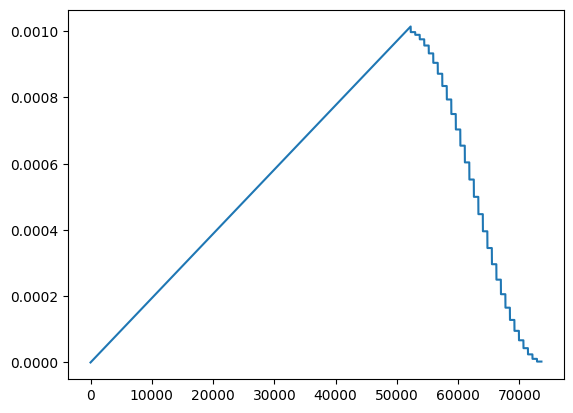

In [14]:
plt.plot(range(len(lr_lists)),lr_lists)   

In [15]:
import torch

In [16]:
A = torch.load('Pretraining/vitmae/vit_base/snapshot.ckpt')

In [18]:
A['MODEL_STATE']

OrderedDict([('cls_token',
              tensor([[[-4.0724e-02, -2.2846e-02, -3.0255e-02, -7.1797e-04, -7.0367e-02,
                        -2.5803e-02, -1.3604e-02, -2.6487e-02, -2.5964e-02, -1.9957e-02,
                        -3.3016e-02, -9.0424e-03, -1.5199e-02, -4.4746e-02, -4.1591e-02,
                        -3.8952e-02, -3.6268e-02, -3.4474e-02, -3.7053e-02, -1.0003e-02,
                        -2.8317e-02, -2.3525e-02, -9.2829e-03,  1.6043e-02, -1.6788e-02,
                         8.5509e-03,  2.3674e-02,  2.6973e-02,  2.7904e-02, -2.3611e-02,
                        -2.6922e-03, -2.4255e-02, -3.3120e-02, -2.9260e-02,  1.9179e-02,
                         1.2997e-03, -8.0231e-03,  4.3501e-03,  6.9503e-04,  2.7650e-04,
                         1.5038e-02, -1.6281e-02, -5.2920e-03,  4.7135e-02,  5.4420e-03,
                        -3.2605e-02,  6.9972e-02,  2.3960e-02, -1.9594e-03,  6.1865e-02,
                         6.3406e-02,  5.1444e-02,  1.3246e-01,  4.5127e-02,  6.3508

In [1]:
import torch